# **Import Dataset**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


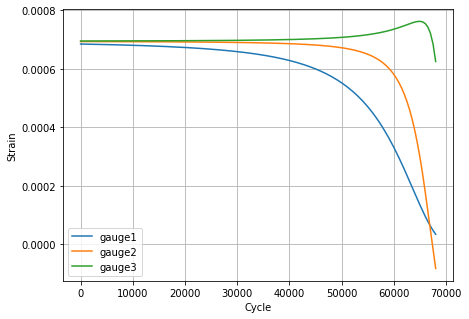

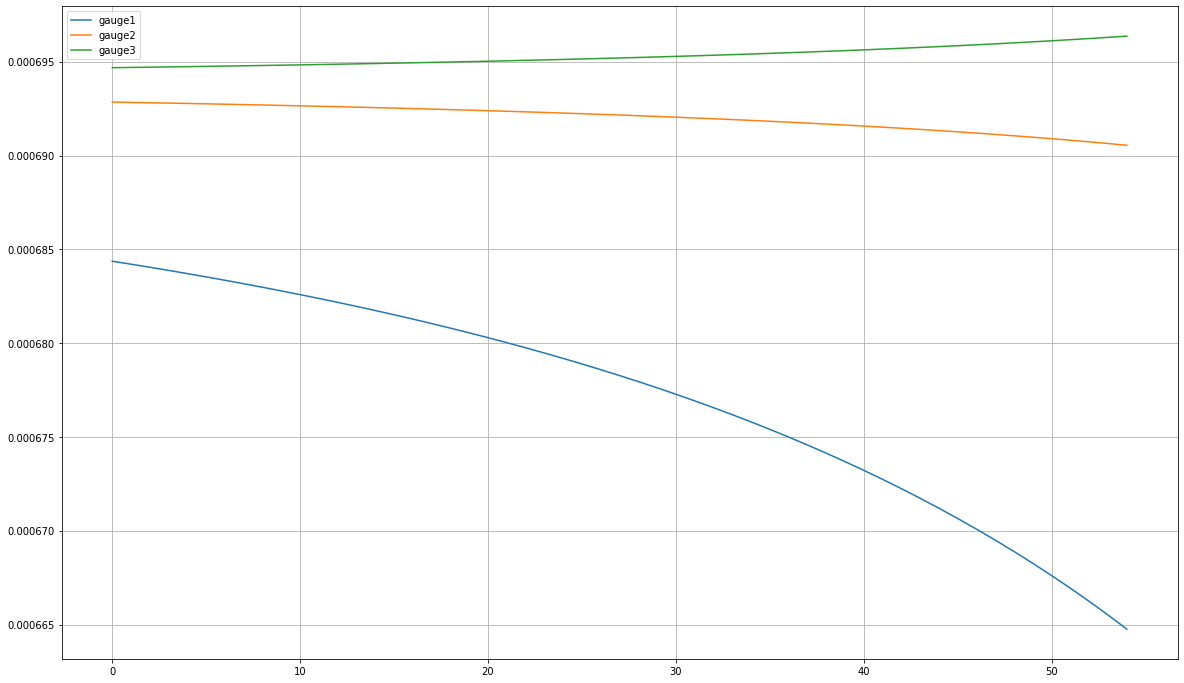

In [8]:
!pip3 install pickle5
import pickle5 as pc

from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
from datetime import datetime
import tensorflow as tf

# set random seed for random weights
np.random.seed(1)
tf.random.set_seed(1)
fd='/content/drive/MyDrive/PIR_perso'
fk='/data'
with open(fd + fk + '/data_train_v1', "rb") as fh:
  data_train = pc.load(fh).reset_index().iloc[:,1:]
with open(fd + fk +'/data_test_v1', "rb") as fh:
  data_test = pc.load(fh).reset_index().iloc[:,1:]

#data_train[data_train.ID == 1]

fig, ax = plt.subplots(figsize=(7,5))

ax.plot(data_train[data_train.ID == 1]['cycle'],data_train[data_train.ID == 1]['gauge1'],label= 'gauge1')
ax.plot(data_train[data_train.ID == 1]['cycle'],data_train[data_train.ID == 1][ 'gauge2'],label= 'gauge2')
ax.plot(data_train[data_train.ID == 1]['cycle'],data_train[data_train.ID == 1]['gauge3'], label= 'gauge3')
ax.grid()
ax.legend()

ax.set(xlabel='Cycle', ylabel='Strain')

plt.savefig('training_data_ID_1.pdf', bbox_inches='tight')

plt.show()

#data_train.head(10)

#data_test[data_test.ID==1]

plt.figure(figsize=(20, 12))
plt.plot(data_test[data_test.ID == 1]['gauge1'],label= 'gauge1')
plt.plot(data_test[data_test.ID == 1][ 'gauge2'],label= 'gauge2')
plt.plot(data_test[data_test.ID == 1]['gauge3'], label= 'gauge3')
plt.grid()
plt.legend()
plt.show()

# **Categorize Data**

count    1.385083e+06
mean     3.477047e+04
std      2.023644e+04
min      0.000000e+00
25%      1.731200e+04
50%      3.462700e+04
75%      5.193900e+04
max      8.189600e+04
Name: RUL, dtype: float64
count     8782.000000
mean     45427.648144
std      15643.733322
min       3964.000000
25%      34177.000000
50%      46891.000000
75%      57867.500000
max      79327.000000
Name: RUL, dtype: float64
[    0.           221.6066482    886.4265928   1994.4598338
  3545.70637119  5540.16620499  7977.83933518 10858.72576177
 14182.82548476 17950.13850416 22160.66481994 26814.40443213
 31911.35734072 37451.52354571 43434.90304709 49861.49584488
 56731.30193906 64044.32132964 71800.55401662 80000.        ]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


,ID,cycle,gauge1,gauge2,gauge3,RUL,RUL_bins
0,1,0,0.000684,0.000693,0.000695,68053,17
1,1,500,0.000684,0.000693,0.000695,67553,17
2,1,1000,0.000684,0.000693,0.000695,67053,17
3,1,1500,0.000684,0.000693,0.000695,66553,17
4,1,2000,0.000684,0.000693,0.000695,66053,17
...,...,...,...,...,...,...,...
1385078,10000,66500,0.000118,0.000253,0.000761,2393,3
1385079,10000,67000,0.000097,0.000186,0.000755,1893,2
1385080,10000,67500,0.000078,0.000113,0.000743,1393,2
1385081,10000,68000,0.000060,0.000037,0.000718,893,2


,ID,cycle,gauge1,gauge2,gauge3,RUL,RUL_bins
0,1,0,0.000684,0.000693,0.000695,64540,17
1,1,500,0.000684,0.000693,0.000695,64040,16
2,1,1000,0.000684,0.000693,0.000695,63540,16
3,1,1500,0.000684,0.000693,0.000695,63040,16
4,1,2000,0.000684,0.000693,0.000695,62540,16
...,...,...,...,...,...,...,...
8777,100,22000,0.000670,0.000691,0.000696,43346,13
8778,100,22500,0.000670,0.000691,0.000696,42846,13
8779,100,23000,0.000669,0.000691,0.000696,42346,13
8780,100,23500,0.000669,0.000691,0.000696,41846,13


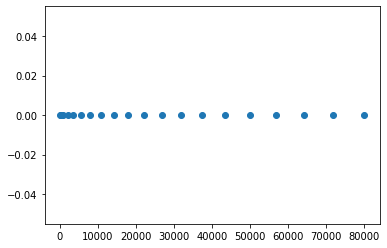

In [9]:
print(data_train.RUL.describe())
print(data_test.RUL.describe())

l=0.5
nb_bins = 20
lower_bin_bound = 0
upper_bin_bound = 80000

bins = np.linspace(lower_bin_bound, upper_bin_bound**(1-l), nb_bins)**(1/l)
labels=[i for i in range(bins.shape[0]-1)]
plt.plot(bins,np.full(bins.shape[0],0),'o')
print(bins)
print(labels)

data_train['RUL_bins'] = pd.cut(data_train['RUL'], bins=bins, labels=labels)
data_test['RUL_bins'] = pd.cut(data_test['RUL'], bins=bins, labels=labels)

display(data_train)
display(data_test)

# **Build Sequences**

In [10]:
#utils 
nb_gauges = 3
data_tr = data_train[data_train.ID <= 1000]
data_val = data_train[data_train.ID > 9900]

#prepare forecasting data
def gen_X_sequence(id_df, seq_length, seq_cols,timesteps_pred,  type_data = None):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    
    
    ind_start = 0
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0+ind_start, num_elements-seq_length+1-timesteps_pred), range(seq_length+ind_start, num_elements+1-timesteps_pred)):
        yield data_array[start:stop, :]
 

def gen_Y_sequence(id_df, seq_length, seq_cols,timesteps_pred, type_data = None):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    
    
    ind_start = 0
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0+ind_start, num_elements-seq_length+1-timesteps_pred), range(seq_length+ind_start, num_elements+1-timesteps_pred)):
        yield data_array[stop-1, :]#data_array[start+1:stop+1, :]
   
#prepare data
seq_cols =  ['gauge'+str(i) for i in range(1,4)]#['label'+str(i) for i in range(1,4)]
seq_cols1 =  ['RUL_bins']
sequence_length = 30
timesteps_pred = 1



#training set
seq_gen = (list(gen_X_sequence(data_tr[data_tr['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                   for id in data_tr['ID'].unique())
# generate sequences and convert to numpy array
dbX = np.concatenate(list(seq_gen))



seq_gen = (list(gen_Y_sequence(data_tr[data_tr['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                   for id in data_tr['ID'].unique())
# generate sequences and convert to numpy array
dbY = np.concatenate(list(seq_gen))#.astype(np.long).reshape(-1,)


print(dbX.shape)
print(dbY.shape)

#validation set
seq_gen = (list(gen_X_sequence(data_val[data_val['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                   for id in data_val['ID'].unique())

# generate sequences and convert to numpy array
dbX_val = np.concatenate(list(seq_gen))#.astype(np.long)

seq_gen = (list(gen_Y_sequence(data_val[data_val['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                   for id in data_val['ID'].unique())
# generate sequences and convert to numpy array
dbY_val = np.concatenate(list(seq_gen))#.astype(np.long).reshape(-1,)


#test set
dbX_test = [data_test[data_test['ID']==id][seq_cols].values[-sequence_length:] for id in data_test['ID'].unique()]
dbX_test = np.asarray(dbX_test)

dbY_test = [data_test[data_test['ID']==id][seq_cols1].values[-1] for id in data_test['ID'].unique()]
dbY_test = np.asarray(dbY_test)



print(dbX_val.shape)
print(dbY_val.shape)

(108452, 30, 3)
(108452, 1)
(10937, 30, 3)
(10937, 1)


# **Normalize Data and One Hot Encoding**

In [11]:
from tensorflow.keras.utils import to_categorical

dbY = to_categorical(dbY,nb_bins)
dbY_val = to_categorical(dbY_val,nb_bins)
dbY_test = to_categorical(dbY_test,nb_bins)

print(dbX.shape)
dbX[:,:,0].max()
for k in range(3) :
  a = dbX[:,:,k].max()
  b = dbX[:,:,k].min()
  dbX[:,:,k] = (dbX[:,:,k] - b)/(a-b)
  dbX_val[:,:,k] = (dbX_val[:,:,k] - b)/(a-b)
  dbX_test[:,:,k] = (dbX_test[:,:,k] - b)/(a-b)


dbX
dbX_val


(108452, 30, 3)


array([[[0.9978584 , 0.99979255, 0.28970873],
        [0.99761952, 0.99976932, 0.28984602],
        [0.99737514, 0.99974553, 0.28998649],
        ...,
        [0.98888546, 0.99890684, 0.29488626],
        [0.98841977, 0.99886014, 0.29515616],
        [0.98794128, 0.99881207, 0.29543359]],

       [[0.99761952, 0.99976932, 0.28984602],
        [0.99737514, 0.99974553, 0.28998649],
        [0.9971251 , 0.99972117, 0.29013025],
        ...,
        [0.98841977, 0.99886014, 0.29515616],
        [0.98794128, 0.99881207, 0.29543359],
        [0.98744955, 0.9987626 , 0.29571882]],

       [[0.99737514, 0.99974553, 0.28998649],
        [0.9971251 , 0.99972117, 0.29013025],
        [0.99686923, 0.99969622, 0.29027739],
        ...,
        [0.98794128, 0.99881207, 0.29543359],
        [0.98744955, 0.9987626 , 0.29571882],
        [0.98694413, 0.99871166, 0.29601214]],

       ...,

       [[0.78066215, 0.96889689, 0.42868387],
        [0.76994113, 0.96672914, 0.43637674],
        [0.75857793, 0

# **Build the model**

In [ ]:
dbY.shape

(10956, 20)

In [12]:
from tensorflow import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import *


model_path = '/content/drive/MyDrive/PIR_perso/models_GRU/1000_structures'
import json
json_file = open(model_path + '/GRU_1000_tuned.json')
loaded_model = json_file.read()
json_file.close()
model = model_from_json(loaded_model)
model.load_weights(model_path + '/GRU_1000_tuned.h5')
model.get_config()
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 3)]           0         
_________________________________________________________________
gru (GRU)                    (None, 30, 256)           200448    
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               394752    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                5140      
Total params: 600,340
Trainable params: 600,340
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow import keras
from keras.layers.recurrent import LSTM, GRU, RNN
from keras.models import *
from keras.layers import *


history_seq = Input(shape = (dbX.shape[1],dbX.shape[2]))
x = history_seq
x = GRU(256, return_sequences=True, dropout=0, recurrent_dropout=0)(x)
x = GRU(256, return_sequences=False, dropout=0, recurrent_dropout=0)(x)
x = Activation('relu')(x)
x = Dense(dbY.shape[1], activation = 'softmax')(x)
model = Model(history_seq, x)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 3)]           0         
_________________________________________________________________
gru (GRU)                    (None, 30, 256)           200448    
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               394752    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                5140      
Total params: 600,340
Trainable params: 600,340
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dbX.shape[1]

30

# **Compile and train**

In [ ]:
dbY.shape

(10956, 20)

In [ ]:
from keras.optimizers import Adam
import keras.backend as K




List_lr=[0.01, 0.001, 0.0001, 0.00001]
learning_rate = List_lr[0]
lr_step = '0'
i=0
opt = Adam(learning_rate=learning_rate)

List_hist=[]
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
temp_model = model

for i in range (0,len(List_lr)):


  # ES = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0, patience=100, verbose=2, mode='max')
  mc = keras.callbacks.ModelCheckpoint('best_model_gru_prob.h5', monitor='accuracy', mode='max', save_best_only=True)

  lr_step = str(i)
  batch_size = 4096
  epochs = 500
  K.set_value(temp_model.optimizer.learning_rate, learning_rate)
  history = temp_model.fit(dbX, dbY, batch_size=batch_size, epochs=epochs, validation_data=(dbX_val, dbY_val), callbacks=[mc])
  List_hist.append(history.history['accuracy'])
  List_hist.append(history.history['val_accuracy'])
  List_hist.append(history.history['loss'])
  List_hist.append(history.history['val_loss'])
  lr_step = str(i)
  learning_rate = List_lr[i]
  temp_model=tf.keras.models.load_model('best_model_gru_prob.h5')




  

Epoch 1/500
27/27 [==============================] - 21s 131ms/step - loss: 2.7815 - accuracy: 0.0884 - val_loss: 2.5346 - val_accuracy: 0.1334
Epoch 2/500
27/27 [==============================] - 3s 102ms/step - loss: 2.4352 - accuracy: 0.1375 - val_loss: 2.0992 - val_accuracy: 0.2503
Epoch 3/500
27/27 [==============================] - 3s 101ms/step - loss: 1.9811 - accuracy: 0.2858 - val_loss: 1.6878 - val_accuracy: 0.3773
Epoch 4/500
27/27 [==============================] - 3s 101ms/step - loss: 1.7241 - accuracy: 0.3319 - val_loss: 1.4939 - val_accuracy: 0.4502
Epoch 5/500
27/27 [==============================] - 3s 101ms/step - loss: 1.4375 - accuracy: 0.4550 - val_loss: 1.3563 - val_accuracy: 0.4542
Epoch 6/500
27/27 [==============================] - 3s 100ms/step - loss: 1.2909 - accuracy: 0.4937 - val_loss: 1.1988 - val_accuracy: 0.5416
Epoch 7/500
27/27 [==============================] - 3s 103ms/step - loss: 1.2943 - accuracy: 0.4750 - val_loss: 1.2830 - val_accuracy: 0.462

# **Evaluate**

In [13]:
from keras.optimizers import Adam
import keras.backend as K
opt = Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.evaluate(dbX_test, dbY_test, batch_size=32)

4/4 [==============================] - 7s 8ms/step - loss: 0.5715 - accuracy: 0.7488


[0.5735406279563904, 0.7599999904632568]

181/181 [==============================] - 1s 4ms/step - loss: 0.6950 - accuracy: 0.6707


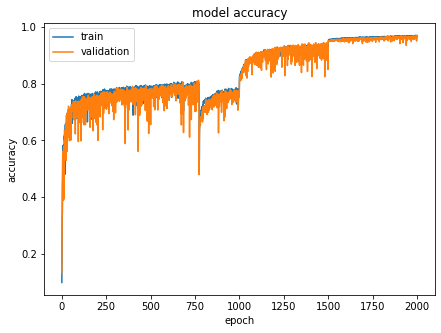

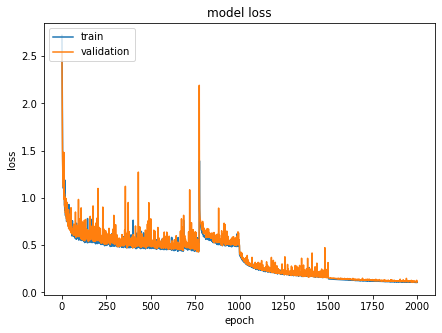

In [ ]:
model_path = '/content/drive/MyDrive/PIR_perso/models_GRU/1000_structures'
# serialize model to JSON
model_json = model.to_json()
with open(model_path + "/GRU_1000_tuned.json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_path + "/GRU_1000_tuned.h5")



model.evaluate(dbX_test, dbY_test, batch_size=32)
# summarize history for accuracy
fig, ax = plt.subplots(figsize=(7,5))
acc = List_hist[0] + List_hist[4] + List_hist[8] + List_hist[12]        # concatenate history for the 3 learning rate to make it a single learning
val_acc = List_hist[1] + List_hist[5] + List_hist[9] + List_hist[13]
loss = List_hist[2] + List_hist[6] + List_hist[10] + List_hist[14]
val_loss = List_hist[3] + List_hist[7] + List_hist[11] + List_hist[15]
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig(model_path + '/GRU_1000_tuned_acc.png')
# summarize history for loss
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig(model_path + '/GRU_1000_tuned_loss.png')